In [92]:
import os
import pandas as pd
import numpy as np
from tbparse import SummaryReader

# log_dir = os.path.expanduser("~/lis-cluster/emergent_communication/emergent_communication/lightning_logs")
log_dir = os.path.expanduser("~/PhD/emergent_communication/emergent_communication/lightning_logs_cluster")

reader = SummaryReader(log_dir, extra_columns={'dir_name'}, pivot=True)
df = reader.scalars

In [97]:
df.dropna(subset=["best_val_acc_no_noise"], inplace=True)
unfinished_runs = df[df["best_val_acc_no_noise"].apply(isinstance, args=(list, ))]
print(f"Unfinished/Duplicate runs: {unfinished_runs.dir_name.unique()}")
df = df[~df["best_val_acc_no_noise"].apply(isinstance, args=(list,))].copy()

# Keep only best step values for each run
df["best_val_acc_no_noise"] = df["best_val_acc_no_noise"].astype(float)
indices_best_steps = df.groupby(["dir_name"])["best_val_acc_no_noise"].idxmax() #.aggregate({"best_val_acc_no_noise": max}).idxmax()
df = df.loc[indices_best_steps]
df

Unfinished/Duplicate runs: ['version_1053742' 'version_1053743' 'version_1053744' 'version_1053745'
 'version_1053746']


,step,best_val_acc_no_noise,bosdis,bosdis_at_best_val_acc,entropy_loss,entropy_loss/dataloader_idx_0,entropy_loss/dataloader_idx_1,entropy_loss/dataloader_idx_2,epoch,hp_metric,...,test_acc,test_acc_no_noise,topsim,topsim_at_best_val_acc,train_acc,train_acc_no_noise,train_acc_no_noise_at_best_val_acc,val_acc,val_acc_no_noise,dir_name
50,2499,1.000000,0.110944,0.110944,0.094175,0.097214,0.086236,0.096345,"[2499.0, 2499.0]",NaN,...,0.884615,0.884615,0.567532,0.567532,0.985507,1.0,1.0,1.0,1.0,version_1053667
295,7199,1.000000,0.061478,0.061478,0.362947,0.359391,0.367527,0.365527,"[7199.0, 7199.0]",NaN,...,1.0,1.0,0.554759,0.554759,0.990338,1.0,1.0,0.913043,1.0,version_1053668
564,8399,1.000000,0.113361,0.113361,0.138065,0.141128,0.129169,0.138643,"[8399.0, 8399.0]",NaN,...,0.923077,0.923077,0.521529,0.521529,0.995169,1.0,1.0,1.0,1.0,version_1053669
751,4299,1.000000,0.093255,0.093255,0.348223,0.342142,0.356651,0.349823,"[4299.0, 4299.0]",NaN,...,0.961538,1.0,0.478973,0.478973,0.975845,1.0,1.0,0.913043,1.0,version_1053670
926,3699,1.000000,0.084773,0.084773,0.10164,0.112596,0.109427,0.108363,"[3699.0, 3699.0]",NaN,...,0.923077,0.923077,0.544981,0.544981,0.975845,1.0,1.0,1.0,1.0,version_1053671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128994,3499,0.565217,0.06852,0.06852,6.278036,6.352735,6.339238,6.301297,"[3499.0, 3499.0]",NaN,...,0.538462,0.576923,0.415168,0.415168,0.68599,0.985507,0.985507,0.347826,0.565217,version_1054880
129068,3499,1.000000,0.08219,0.08219,2.750644,2.790627,2.787009,2.792101,"[3499.0, 3499.0]",NaN,...,1.0,1.0,0.517991,0.517991,0.845411,1.0,1.0,1.0,1.0,version_1054881
129139,3499,0.608696,0.071656,0.071656,6.291538,6.327806,6.34631,6.294819,"[3499.0, 3499.0]",NaN,...,0.538462,0.538462,0.409452,0.409452,0.73913,0.995169,0.995169,0.434783,0.608696,version_1054882
129280,4499,0.913043,0.057053,0.057053,2.744301,2.767714,2.769577,2.790692,"[4499.0, 4499.0]",NaN,...,0.884615,0.884615,0.434185,0.434185,0.826087,0.995169,0.995169,0.913043,0.913043,version_1054883


In [98]:
hp = reader.hparams
hp = hp[~hp["num_values"].apply(isinstance, args=(list,))].copy()

hp

,accelerator,accumulate_grad_batches,amp_backend,amp_level,auto_lr_find,auto_scale_batch_size,auto_select_gpus,baseline_type,batch_size,benchmark,...,sync_batchnorm,terminate_on_nan,test_set_size,tpu_cores,track_grad_norm,val_check_interval,vocab_size,weights_save_path,weights_summary,dir_name
0,None,None,native,None,0.0,0.0,0.0,mean,5120.0,0.0,...,0.0,None,0.1,None,-1.0,1.0,100.0,None,top,version_1053667
1,None,None,native,None,0.0,0.0,0.0,mean,5120.0,0.0,...,0.0,None,0.1,None,-1.0,1.0,100.0,None,top,version_1053668
2,None,None,native,None,0.0,0.0,0.0,mean,5120.0,0.0,...,0.0,None,0.1,None,-1.0,1.0,100.0,None,top,version_1053669
3,None,None,native,None,0.0,0.0,0.0,mean,5120.0,0.0,...,0.0,None,0.1,None,-1.0,1.0,100.0,None,top,version_1053670
4,None,None,native,None,0.0,0.0,0.0,mean,5120.0,0.0,...,0.0,None,0.1,None,-1.0,1.0,100.0,None,top,version_1053671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,None,None,native,None,0.0,0.0,0.0,mean,5120.0,0.0,...,0.0,None,0.1,None,-1.0,1.0,100.0,None,top,version_1054880
476,None,None,native,None,0.0,0.0,0.0,mean,5120.0,0.0,...,0.0,None,0.1,None,-1.0,1.0,100.0,None,top,version_1054881
477,None,None,native,None,0.0,0.0,0.0,mean,5120.0,0.0,...,0.0,None,0.1,None,-1.0,1.0,100.0,None,top,version_1054882
478,None,None,native,None,0.0,0.0,0.0,mean,5120.0,0.0,...,0.0,None,0.1,None,-1.0,1.0,100.0,None,top,version_1054883


In [104]:
df["dir_name"] = df.dir_name.astype(str)
hp["dir_name"] = hp.dir_name.astype(str)
df.set_index("dir_name", inplace=True)
hp.set_index("dir_name", inplace=True)
df = df.join(hp, how="left")


In [131]:
#TODO
NUM_SENDERS = 1
NUM_RECEIVERS = 1

assert (df.sender_entropy_coeff == df.receiver_entropy_coeff).all()
assert (df.sender_layer_norm == df.receiver_layer_norm).all()

df["layer_norm"] = df["sender_layer_norm"]
df["entropy_coeff"] = df["sender_entropy_coeff"]

runs_best_entropy = []

df.dropna(subset=["num_attributes", "num_values"], inplace=True)

df["attr_val"] = df["num_attributes"].map(int).map(str) + "_" + df["num_values"].map(int).map(str)
attr_val_combinations = df["attr_val"].unique()

for attr_val in attr_val_combinations:
    n_attributes = int(float(attr_val.split("_")[0]))
    n_values = int(float(attr_val.split("_")[1]))
    print(f"\nAttr: {n_attributes} Values: {n_values}")

    length_cost_values = df["length_cost"].unique()
    for length_cost in length_cost_values:
        print(f"\tLength cost: {length_cost}")

        for layer_norm in (0, 1):
            print("\t\tLayer norm") if layer_norm else print("\t\tNo Layer norm")

            for feedback in (0, 1):
                print("\t\t\tFeedback") if feedback else print("\t\t\tBaseline")

                df_config = df[(df.attr_val == attr_val) & (df.length_cost == length_cost) & (df.layer_norm == layer_norm) & (df.feedback == feedback)]

                print(f"\t\t\t\tFound {len(df_config)} runs for config") #: {df_config}

                if len(df_config) == 0:
                    continue

                # TODO handle tie case?
                best_entropy_coeff = df_config.groupby("sender_entropy_coeff").aggregate({"best_val_acc_no_noise": "mean"}).idxmax()

                print("\t\t\t\tbest entropy coeff: ", best_entropy_coeff[0])
                df_best_entropy = df_config[df_config.entropy_coeff == best_entropy_coeff[0]]

                runs_best_entropy.append(df_best_entropy)

data = pd.concat(runs_best_entropy, ignore_index=True)



Attr: 4 Values: 4
	Length cost: 0.0
		No Layer norm
			Baseline
				Found 75 runs for config
				best entropy coeff:  0.1
			Feedback
				Found 25 runs for config
				best entropy coeff:  0.3
		Layer norm
			Baseline
				Found 75 runs for config
				best entropy coeff:  0.05
			Feedback
				Found 25 runs for config
				best entropy coeff:  0.05
	Length cost: 0.001
		No Layer norm
			Baseline
				Found 0 runs for config
			Feedback
				Found 25 runs for config
				best entropy coeff:  0.05
		Layer norm
			Baseline
				Found 0 runs for config
			Feedback
				Found 25 runs for config
				best entropy coeff:  0.05
	Length cost: 0.01
		No Layer norm
			Baseline
				Found 0 runs for config
			Feedback
				Found 25 runs for config
				best entropy coeff:  0.1
		Layer norm
			Baseline
				Found 0 runs for config
			Feedback
				Found 25 runs for config
				best entropy coeff:  0.05

Attr: 2 Values: 100
	Length cost: 0.0
		No Layer norm
			Baseline
				Found 13 runs for config
				best entropy

/home/mitja/anaconda3/envs/emergent_communication/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 36.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


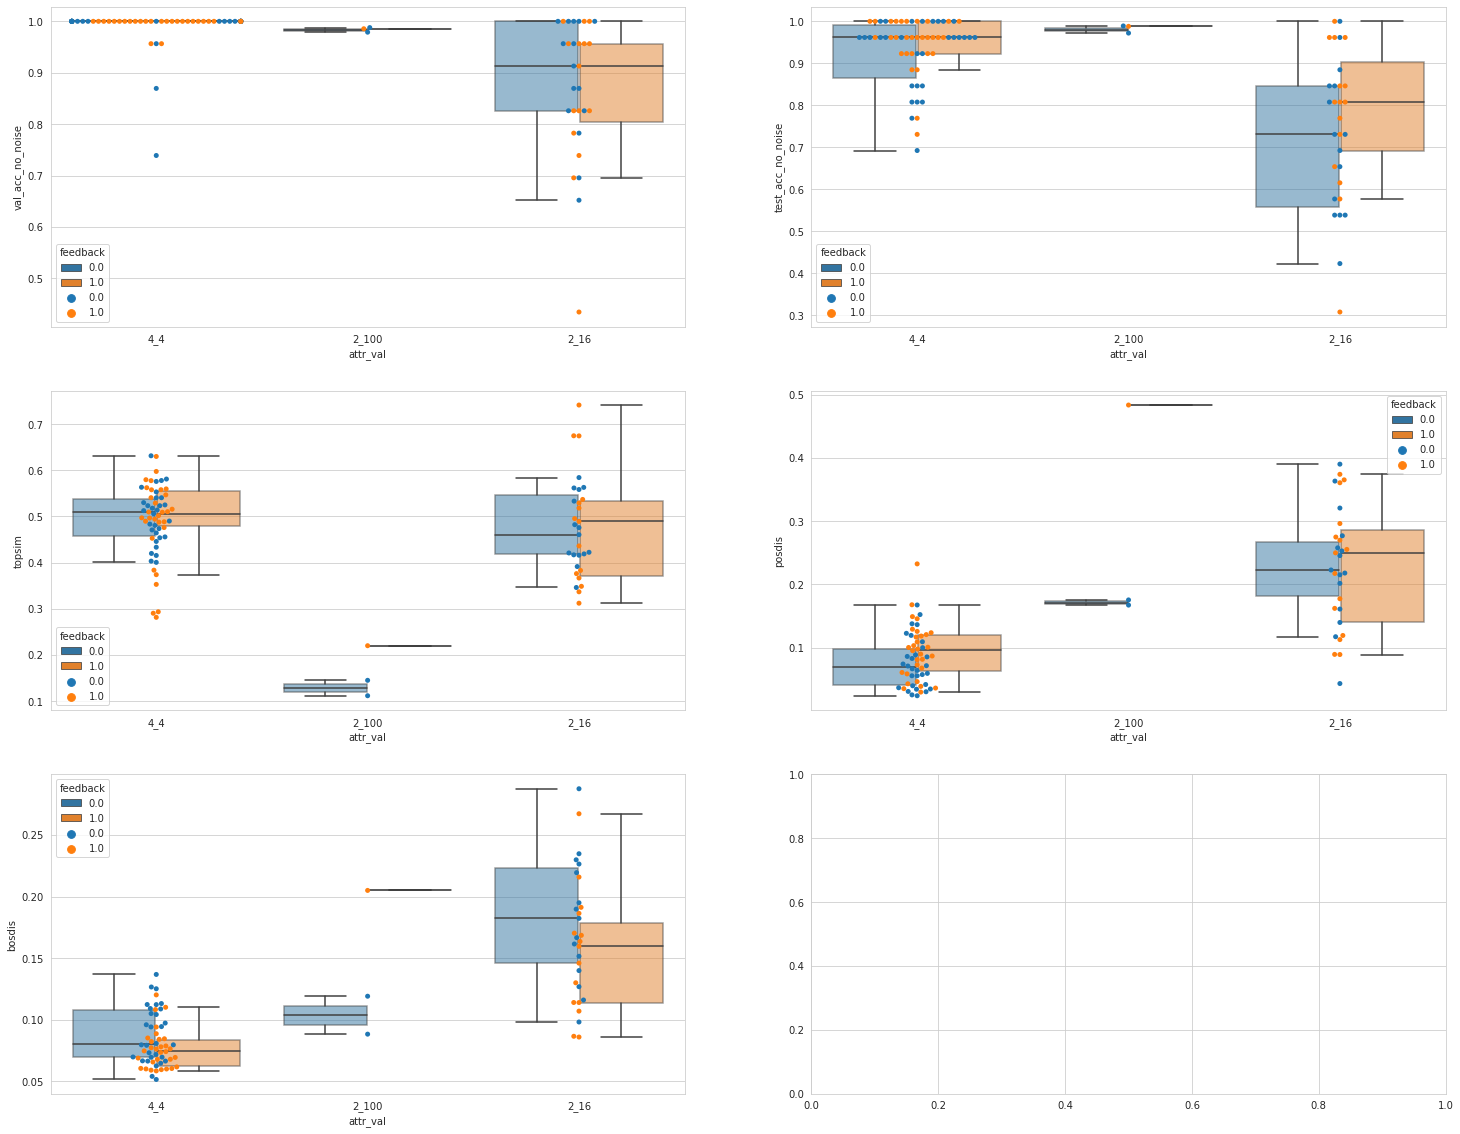

In [132]:
import seaborn as sns
import matplotlib.pyplot as plt

_, axes = plt.subplots(3, 2, figsize=(25, 20))
sns.boxplot(ax=axes[0, 0], data=data, x="attr_val", y="val_acc_no_noise", hue="feedback", boxprops=dict(alpha=.5), showfliers = False)
sns.swarmplot(ax=axes[0, 0], data=data, x="attr_val", y="val_acc_no_noise", hue="feedback")

sns.boxplot(ax=axes[0, 1], data=data, x="attr_val", y="test_acc_no_noise", hue="feedback", boxprops=dict(alpha=.5), showfliers = False)
sns.swarmplot(ax=axes[0, 1], data=data, x="attr_val", y="test_acc_no_noise", hue="feedback")

sns.boxplot(ax=axes[1, 0], data=data, x="attr_val", y="topsim", hue="feedback", boxprops=dict(alpha=.5), showfliers = False)
sns.swarmplot(ax=axes[1, 0], data=data, x="attr_val", y="topsim", hue="feedback")

sns.boxplot(ax=axes[1, 1], data=data, x="attr_val", y="posdis", hue="feedback", boxprops=dict(alpha=.5), showfliers = False)
sns.swarmplot(ax=axes[1, 1], data=data, x="attr_val", y="posdis", hue="feedback")

sns.boxplot(ax=axes[2, 0], data=data, x="attr_val", y="bosdis", hue="feedback", boxprops=dict(alpha=.5), showfliers = False)
sns.swarmplot(ax=axes[2, 0], data=data, x="attr_val", y="bosdis", hue="feedback")


name = log_dir.split("/")[-1]
plt.savefig("plots/"+name+".pdf", dpi=300)



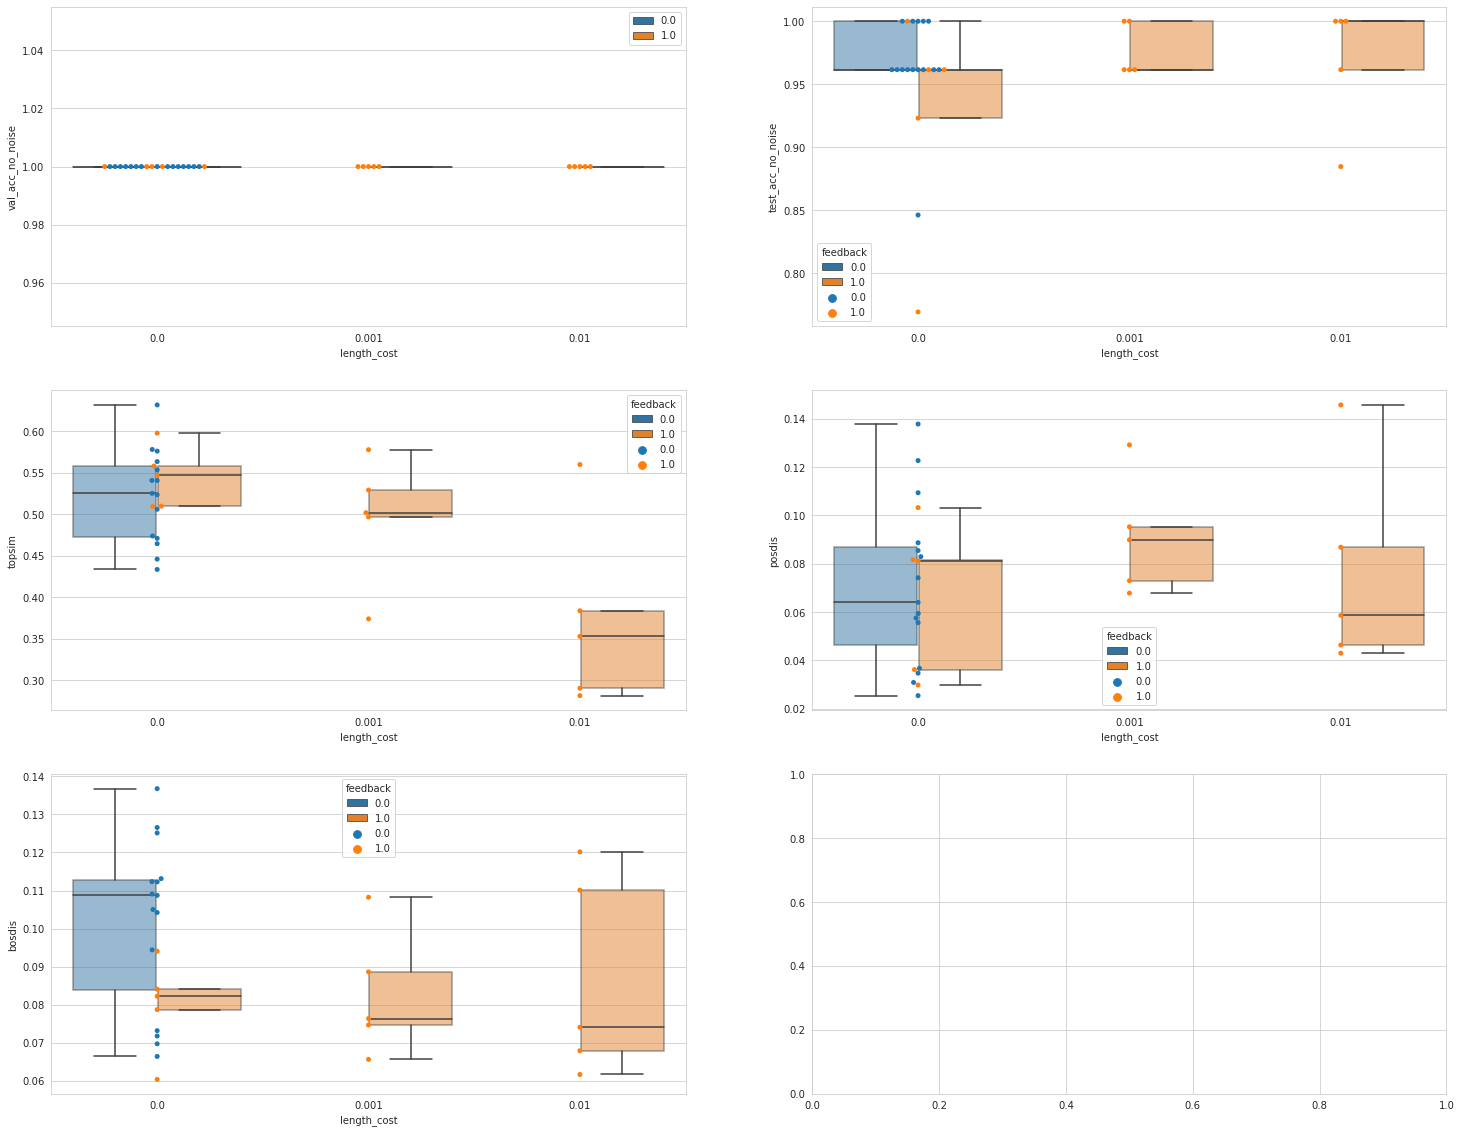

In [133]:
import seaborn as sns
import matplotlib.pyplot as plt

ATTR_VAL = "4_4"
target_data = data[(data["attr_val"] == ATTR_VAL) & (data["layer_norm"] == 1)]

# data_4_4 = data[(data["attr_val"] == ATTR_VAL) & (data["length_cost"] == 0)]
# data_4_4 = data[(data["attr_val"] == ATTR_VAL) & ((data["length_cost"] != 0) | (data["feedback"] == 0))]

target_hparam = "length_cost"
# target_hparam = "layer_norm"

_, axes = plt.subplots(3, 2, figsize=(25, 20))
sns.boxplot(ax=axes[0, 0], data=target_data, x=target_hparam, y="val_acc_no_noise", hue="feedback", boxprops=dict(alpha=.5), showfliers = False)
ax = sns.swarmplot(ax=axes[0, 0], data=target_data, x=target_hparam, y="val_acc_no_noise", hue="feedback")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2])

sns.boxplot(ax=axes[0, 1], data=target_data, x=target_hparam, y="test_acc_no_noise", hue="feedback", boxprops=dict(alpha=.5), showfliers = False)
sns.swarmplot(ax=axes[0, 1], data=target_data, x=target_hparam, y="test_acc_no_noise", hue="feedback")

sns.boxplot(ax=axes[1, 0], data=target_data, x=target_hparam, y="topsim", hue="feedback", boxprops=dict(alpha=.5), showfliers = False)
sns.swarmplot(ax=axes[1, 0], data=target_data, x=target_hparam, y="topsim", hue="feedback")

sns.boxplot(ax=axes[1, 1], data=target_data, x=target_hparam, y="posdis", hue="feedback", boxprops=dict(alpha=.5), showfliers = False)
sns.swarmplot(ax=axes[1, 1], data=target_data, x=target_hparam, y="posdis", hue="feedback")

sns.boxplot(ax=axes[2, 0], data=target_data, x=target_hparam, y="bosdis", hue="feedback", boxprops=dict(alpha=.5), showfliers = False)
sns.swarmplot(ax=axes[2, 0], data=target_data, x=target_hparam, y="bosdis", hue="feedback")


name = log_dir.split("/")[-2]
plt.savefig("plots/"+name+".pdf", dpi=300)

